In [1]:
# this is a little trick to make sure the the notebook takes up most of the screen:
from IPython.display import HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Recommendation to leave the logging config like this, otherwise you'll be flooded with unnecessary info
import logging
logging.basicConfig(level=logging.WARNING, format='%(levelname)s:%(message)s')  


# Recommendation: logging config like this, otherwise you'll be flooded with unnecessary information
import logging
logging.basicConfig(level=logging.ERROR)

import sys
sys.path.append('../')

In [2]:
# import all modeling concepts
from crestdsl.model import *

# import the simulator
from crestdsl.simulation import Simulator

# import the plotting libraries that can visualise the CREST systems
from crestdsl.ui import elk

# we will create tests for each Entity
import unittest

class TestClass(unittest.TestCase):
    @classmethod
    def runall(cls):
        tests = unittest.TestLoader().loadTestsFromTestCase(cls)
        return unittest.TextTestRunner().run(tests)
    


In [3]:
class Resources(object):
    electricity = Resource("Watt", REAL)
    switch = Resource("switch", ["on", "off"])
    pourcent = Resource("%", REAL) 
    light = Resource("Lumen", INTEGER)
    time = Resource("minutes", REAL)
    water = Resource("litre", REAL)
    celsius = Resource("Celsius", REAL)    
    counter = Resource("Count", INTEGER)
    fahrenheit = Resource("Fahrenheit", REAL)
    boolean = Resource("bool", BOOL)
    presence = Resource("presence", ["detected", "no presence"])
    onOffAuto = Resource("onOffAutoSwitch", ["on", "off", "auto"])
    integer = Resource("integer", INTEGER)
    weight = Resource("kg", REAL)
    lenght = Resource("m", REAL)
    area = Resource("m²", REAL)

In [4]:
class ElectricalDevice(object):
    electricity_in = Input(Resources.electricity, value=0)
    req_electricity_out = Output(Resources.electricity, value=0)
    
class WaterDevice(object):
    water_in = Input(Resources.water, value=0)
    req_water_out = Output(Resources.water, value=0)

In [5]:
class LightElement(Entity):
    """This is a definition of a new Entity type. It derives from CREST's Entity base class."""
    
    """we define ports - each has a resource and an initial value"""
    electricity = Input(resource=Resources.electricity, value=0)
    light = Output(resource=Resources.light, value=0)
    
    """automaton states - don't forget to specify one as the current state"""
    on = State()
    off = current = State()
    
    """transitions and guards (as lambdas)"""
    off_to_on = Transition(source=off, target=on, guard=(lambda self: self.electricity.value >= 100))
    on_to_off = Transition(source=on, target=off, guard=(lambda self: self.electricity.value < 100))
    
    """
    update functions. They are related to a state, define the port to be updated and return the port's new value
    Remember that updates need two parameters: self and dt.
    """
    @update(state=on, target=light)
    def set_light_on(self, dt=0):
        return 800

    @update(state=off, target=light)
    def set_light_off(self, dt=0):
        return 0

In [6]:
class HeatElement(Entity):
    """ Ports """
    electricity = Input(resource=Resources.electricity, value=0)
    switch = Input(resource=Resources.switch, value="off")  # the heatelement has its own switch
    heat = Output(resource=Resources.celsius, value=0)      # and produces a celsius value (i.e. the temperature increase underneath the lamp)
    
    """ Automaton (States) """
    state = current = State() # the only state of this entity
    
    """Update"""
    @update(state=state, target=heat)
    def heat_output(self, dt):
        # When the lamp is on, then we convert electricity to temperature at a rate of 100Watt = 1Celsius
        if self.switch.value == "on":
            return self.electricity.value / 100
        else:
            return 0

# show us what it looks like
elk.plot(HeatElement())

In [7]:
# a logical entity (this one sums two values)
class Adder(LogicalEntity):
    heat_in = Input(resource=Resources.celsius, value=0)
    room_temp_in = Input(resource=Resources.celsius, value=22)
    temperature = Output(resource=Resources.celsius, value=22)
    
    state = current = State()
    @update(state=state, target=temperature)
    def add(self, dt):
        return self.heat_in.value + self.room_temp_in.value
    
elk.plot(Adder())  # try adding the display option 'show_update_ports=True' and see what happens!

In [8]:
# Entity composed by the 3 subentities above, heats and lights the plant to an optimal value

class GrowLamp(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    electricity = Input(resource=Resources.electricity, value=0)
    switch = Input(resource=Resources.switch, value="off")
    heat_switch = Input(resource=Resources.switch, value="on")
    room_temperature = Input(resource=Resources.fahrenheit, value=71.6)
    
    light = Output(resource=Resources.light, value=3.1415*1000) # note that these are bogus values for now
    temperature = Output(resource=Resources.celsius, value=42) # yes, nonsense..., they are updated when simulated
    
    on_time = Local(resource=Resources.time, value=0)
    on_count = Local(resource=Resources.counter, value=0)
    
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """
    lightelement = LightElement()
    heatelement = HeatElement()
    adder = Adder()
    
    
    """ - - - - - - - INFLUENCES - - - - - - - - - - """
    """
    Influences specify a source port and a target port. 
    They are always executed, independent of the automaton's state.
    Since they are called directly with the source-port's value, a self-parameter is not necessary.
    """
    @influence(source=room_temperature, target=adder.room_temp_in)
    def fahrenheit_to_celsius(value):
        return (value - 32) * 5 / 9
    
    # we can also define updates and influences with lambda functions... 
    heat_to_add = Influence(source=heatelement.heat, target=adder.heat_in, function=(lambda val: val))
    
    # if the lambda function doesn't do anything (like the one above) we can omit it entirely...
    add_to_temp           = Influence(source=adder.temperature, target=temperature)
    light_to_light        = Influence(source=lightelement.light, target=light)
    heat_switch_influence = Influence(source=heat_switch, target=heatelement.switch)
    
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """
    on = State()
    off = current = State()
    error = State()
    
    off_to_on = Transition(source=off, target=on, guard=(lambda self: self.switch.value == "on" and self.electricity.value >= 100))
    on_to_off = Transition(source=on, target=off, guard=(lambda self: self.switch.value == "off" or self.electricity.value < 100))
    
    # transition to error state if the lamp ran for more than 1000.5 time units
    @transition(source=on, target=error)
    def to_error(self):
        """More complex transitions can be defined as a function. We can use variables and calculations"""
        timeout = self.on_time.value >= 1000.5
        heat_is_on = self.heatelement.switch.value == "on"
        return timeout and heat_is_on
    
    """ - - - - - - - UPDATES - - - - - - - - - - """
    # LAMP is OFF or ERROR
    @update(state=[off, error], target=lightelement.electricity)
    def update_light_elec_off(self, dt):
        # no electricity
        return 0

    @update(state=[off, error], target=heatelement.electricity)
    def update_heat_elec_off(self, dt):
        # no electricity
        return 0
    
    
    
    # LAMP is ON
    @update(state=on, target=lightelement.electricity)
    def update_light_elec_on(self, dt):
        # the lightelement gets the first 100Watt
        return 100
    
    @update(state=on, target=heatelement.electricity)
    def update_heat_elec_on(self, dt):
        # the heatelement gets the rest
        return self.electricity.value - 100
        
    @update(state=on, target=on_time)
    def update_time(self, dt):
        # also update the on_time so we know whether we overheat
        return self.on_time.value + dt
        
    """ - - - - - - - ACTIONS - - - - - - - - - - """
    # let's add an action that counts the number of times we switch to state "on"
    @action(transition=off_to_on, target=on_count)
    def count_switching_on(self):
        """
        Actions are functions that are executed when the related transition is fired.
        Note that actions do not have a dt.
        """
        return self.on_count.value + 1

# create an instance!
elk.plot(GrowLamp())

In [9]:
# Really bad model of the light send by the sun taken from the "SmartHome" file


class Sun(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    
    time_In = Input(Resources.time, 0)
    time_Local = Local(Resources.time, 0)
    light_Out = Output(Resources.light, 0)
  
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """
    #None
    
    """ - - - - - - - INFLUENCES - - - - - - - - - - """
    #None
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """        

    state = current = State()
    
    time_propagation = Influence(source = time_In, target = time_Local)
    
    """ - - - - - - - UPDATES - - - - - - - - - - """

    #Je pars ici du principe que dt = 1min
    #On a donc 60*24 = 1440min/jour
    
    "CREER INFLUENCE ENTRE LES VARIABLES DE TEMPS"
    
    @update(state = state, target = light_Out)
    def update_light_out(self, dt):
                
        if(self.time_Local.value%1440 > 21*60):
            light = 0
        elif(self.time_Local.value%1440 > 16*60):
            light = 20000*(21*60-self.time_Local.value)//60 #On veut 20000*un nombre flottant entre 0 et 5
        elif(self.time_Local.value%1440 > 12*60):
            light = 100000
        elif(self.time_Local.value%1440 > 7*60):
            light = 20000*(abs(self.time_Local.value - 7*60))//60  #On veut 20000*un nombre flottant entre 0 et 5
        else:
            light = 0
        
        return light
    
#elk.plot(Sun())

sun=Sun()
sun.time_In.value = 691
ssim=Simulator(sun)
ssim.stabilize()
ssim.plot()

In [10]:
# Used to take water from the grid and sends it to the Plant Reservoir

class Pump(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    
    water_in = Input(Resources.water, 100)
    
    size_pipe = Local(Resources.water, 2)
    
    water_send = Output(Resources.water, 2)

    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """        

    state = current = State()
    
    """ - - - - - - - - - - UPDATES - - - - - - - - - - - - """
    
    @update(state = state, target = water_send)
    def update_water_send(self, dt):
        
        return min(self.water_in.value, self.size_pipe.value)
    
elk.plot(Pump())

In [11]:
# Contains the water for the plants himidity, fill itself with the pump

@dependency(source="water_in", target="water_send")
class PlantReservoir(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    
    water_in = Input(Resources.water, 2)
    water_needed = Input(Resources.water, 2)
    water_send = Output(Resources.water, 2)
    max_cap = Local(Resources.water, 10)
    actual_cap = Local(Resources.water, 1)
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """        

    off = current = State()
    draining = State()
    filling = State()
    
    off_to_draining = Transition(source=off, target=draining, guard=(lambda self: self.water_needed.value > 0 and self.actual_cap.value >= 2))
    off_to_filling = Transition(source=off, target=filling, guard=(lambda self: self.water_needed.value > 0 and self.actual_cap.value < 2))

    filling_to_draining = Transition(source=filling, target=draining, guard=(lambda self: self.actual_cap.value >= self.max_cap.value and self.water_needed.value > 0))
    filling_to_off = Transition(source=filling, target=off, guard=(lambda self: (self.actual_cap.value >= self.max_cap.value and self.water_needed.value == 0) ))# or self.water_in.value == 0))
    
    draining_to_filling = Transition(source=draining, target=filling, guard=(lambda self: self.actual_cap.value <= 2 or (self.water_needed.value == 0 and self.actual_cap.value < self.max_cap.value)))
    draining_to_off = Transition(source = draining, target = off, guard=(lambda self: self.actual_cap.value >= self.max_cap.value and self.water_needed.value == 0))
    
    """ - - - - - - - - - - INFLUENCES - - - - - - - - - - - - """
    
    
    
    @update(state = draining, target = actual_cap)
    def update_actual_cap_drain(self, dt):
        
        return max(self.actual_cap.value - self.water_needed.value*dt,0)
    
    @update(state = filling, target = actual_cap)
    def update_actual_cap_fill(self, dt):
        
        return min(self.actual_cap.value + self.water_in.value*dt, self.max_cap.value)
    
    influ_water_pump = Influence(target = water_send, source = water_needed)

    
elk.plot(PlantReservoir())

In [12]:
# Entity representing the plants humidity, adapting the consumption for the reservoir

class Plants(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    
    water_in = Input(Resources.water, 0)
    
    water_cons = Local(Resources.water, 2)
    
    actual_humidity = Output(Resources.pourcent, 1)
    
    water_needed = Output(Resources.water,2)
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """        

    watering = current = State()
    off = State()
    
    off_to_watering = Transition(source=off, target=watering, guard=(lambda self: self.actual_humidity.value < 50))# and self.water_in.value >= self.water_cons.value))

    watering_to_off = Transition(source=watering, target=off, guard=(lambda self: self.actual_humidity.value > 70))# or self.water_in.value < self.water_cons.value))

    
    
    """ - - - - - - - - - - INFLUENCES - - - - - - - - - - - - """
    
    @update(state = watering, target = actual_humidity)
    def update_actual_humidity_watering(self, dt):
        
        return max(self.actual_humidity.value + 5*dt,0)
    
    @update(state = off, target = actual_humidity)
    def update_actual_humidity_off(self, dt):
        
        return max(self.actual_humidity.value - dt,0)
    
    @update(state = watering, target = water_needed)
    def update_water_needed_watering(self, dt):
        
        return self.water_cons.value
    
    @update(state = off, target = water_needed)
    def update_water_needed_off(self, dt):
        
        return 0
    
    

    
elk.plot(Plants())

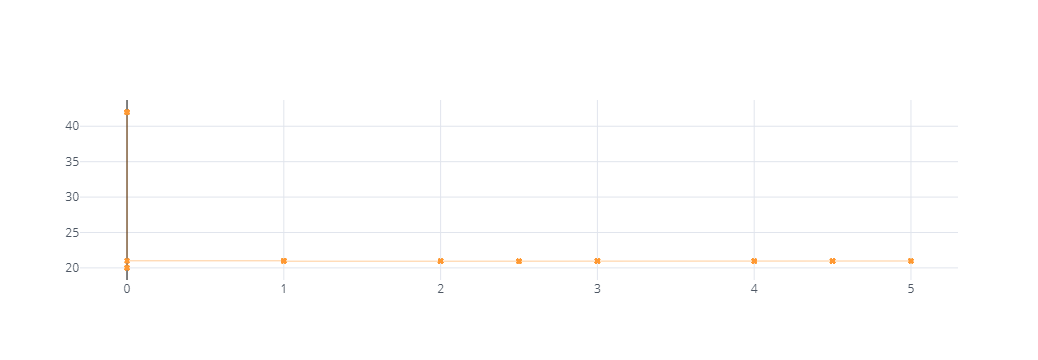

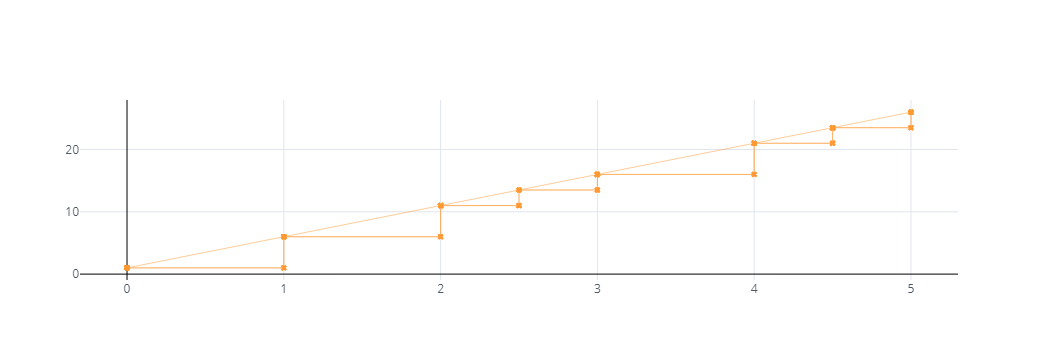

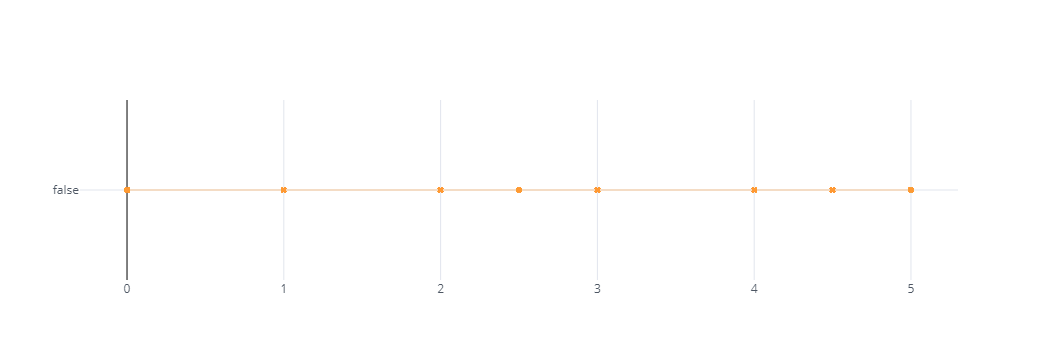

In [13]:
# Entity made with all the subentities above, take account of the humidity, the room temperature and the time (for the sun),
#The output "plant_is_ok is a boolean, true if all 3 are in optimal ranges"

class GrowingPlant(Entity):

    """ - - - - - - - PORTS - - - - - - - - - - """
    electricity_in = Input(Resources.electricity, 200)
    room_temp = Input(Resources.fahrenheit, 0)
    time = Local(Resources.time, 0)
    plant_is_ok = Output(Resources.boolean, False)
        
    def __init__(self, starting_time=0):
        self.time.value = starting_time

    
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """
    
    gl = GrowLamp()
    s = Sun()
    pump = Pump()
    pr = PlantReservoir()
    pl = Plants()
    
    """ - - - - - - - INFLUENCES - - - - - - - - - - """
    
    time_propagation = Influence(source=time, target = s.time_In)
    water_propagation = Influence(source = pump.water_send, target = pr.water_in)
    water_propagation2 = Influence(source = pr.water_send, target = pl.water_in)
    elec_propagation = Influence(source = electricity_in, target = gl.electricity)
    #needed_water_propagation = Influence(source = pr.water_send, target = pump.water_needed)
    needed_water_propagation2 = Influence(source = pl.water_needed, target = pr.water_needed)

    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """
    state = current = State()
    
    """ - - - - - - - UPDATES - - - - - - - - - - """
    
    @update(state=state, target=gl.room_temperature)
    def set_gl_room_temp(self,dt):
        return self.room_temp.value + (self.s.light_Out.value/(1000000)-0.1)*dt
    
    @update(state=state, target=plant_is_ok)
    def set_plant_is_ok(self,dt):
        return ((self.pl.actual_humidity.value>=50)and(self.pl.actual_humidity.value<=70)
                and(self.gl.temperature.value>=20)and(self.gl.temperature.value<=25))
    
    
#elk.plot(GrowingPlant())

gPlant = GrowingPlant()
gPlant.room_temp.value = 68
gPlant.gl.switch.value = "on"
gPlant.pump.water_in.value = 100
gPlant.pl.water_in.value = 100
simuLamp = Simulator(gPlant)
simuLamp.stabilize()
#simuLamp.advance(3)
for i in range(5):
    simuLamp.advance(1)
simuLamp.plot()
simuLamp.traces.plot(traces=[gPlant.gl.temperature])
simuLamp.traces.plot(traces=[gPlant.pl.actual_humidity])
simuLamp.traces.plot(traces=[gPlant.plant_is_ok])